In [5]:
#Install dependencies
!pip install torchaudio torchmetrics pytorch-lightning librosa --quiet
# Uninstall existing conflicting versions
!pip uninstall -y torch torchvision torchaudio

# Install compatible versions together (torch 2.5.0 + torchvision 0.20.0)
!pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 torchmetrics pytorch-lightning librosa --quiet


Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.20.0
Uninstalling torchvision-0.20.0:
  Successfully uninstalled torchvision-0.20.0
Found existing installation: torchaudio 2.6.0
Uninstalling torchaudio-2.6.0:
  Successfully uninstalled torchaudio-2.6.0


In [7]:
import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchmetrics import Accuracy
from glob import glob

In [9]:
class RawAudioDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        waveform, _ = torchaudio.load(self.files[idx])
        label = torch.tensor(self.labels[idx])
        return waveform.squeeze(), label

In [13]:
#Model Definition
class SimpleRawNet(nn.Module):
    def __init__(self):
        super(SimpleRawNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

In [15]:
class AudioClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=2)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

In [ ]:
# # Cell 1: Unzip the file
# import zipfile
# import os

# zip_path = 'archive (1).zip'
# extract_path = 'audio_data'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# # Cell 2: Get audio file paths
# from glob import glob

# # Get all .wav files (limit to 100 for now)
# files = glob(os.path.join(extract_path, '**', '*.wav'), recursive=True)[:100]

# # Cell 3: Create labels (0 = bonafide, 1 = spoof)
# labels = [0 if 'bonafide' in f.lower() else 1 for f in files]

# # Cell 4: Define Dataset class
# from torch.utils.data import Dataset, DataLoader
# import torchaudio

# class RawAudioDataset(Dataset):
#     def __init__(self, file_paths, labels):
#         self.file_paths = file_paths
#         self.labels = labels
        
#     def __len__(self):
#         return len(self.file_paths)
    
#     def __getitem__(self, idx):
#         audio, sr = torchaudio.load(self.file_paths[idx])
#         # Make sure audio has 2 channels
#         if audio.size(0) == 1:  # If mono
#             audio = audio.repeat(2, 1)  # Convert to stereo by duplicating
#         return audio, self.labels[idx]

# import torch.nn.functional as F

# def custom_collate_fn(batch, target_length=80000):
#     padded_waveforms = []
#     labels = []
#     for waveform, label in batch:
#         waveform = waveform.squeeze(0)  # shape: [T]
#         if waveform.size(0) > target_length:
#             waveform = waveform[:target_length]
#         elif waveform.size(0) < target_length:
#             pad_size = target_length - waveform.size(0)
#             waveform = F.pad(waveform, (0, pad_size))
#         padded_waveforms.append(waveform.unsqueeze(0))  # shape: [1, T]
#         labels.append(label)
#     return torch.stack(padded_waveforms), torch.tensor(labels)

# # Cell 5: Create Dataset and DataLoader with custom collate
# dataset = RawAudioDataset(files, labels)
# loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)


# def custom_collate_fn(batch, target_length=160000):
#     padded_waveforms = []
#     labels = []
    
#     for waveform, label in batch:
#         # Make sure all waveforms have the same shape [C, T]
#         if waveform.shape[1] > target_length:
#             # Truncate to target length
#             waveform = waveform[:, :target_length]
#         elif waveform.shape[1] < target_length:
#             # Calculate padding needed
#             padding = target_length - waveform.shape[1]
#             # Pad the time dimension (dim=1)
#             waveform = F.pad(waveform, (0, padding))
            
#         padded_waveforms.append(waveform)
#         labels.append(label)
    
#     # Stack tensors along batch dimension
#     return torch.stack(padded_waveforms), torch.tensor(labels)




# # Cell 6: Define Model
# import torch
# import torch.nn as nn
# import pytorch_lightning as pl

# class SimpleRawNet(nn.Module):
#     def __init__(self):
#         super(SimpleRawNet, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv1d(2, 16, kernel_size=5, stride=2),  # Fixed to 2 input channels
#             nn.ReLU(),
#             nn.Conv1d(16, 32, kernel_size=5, stride=2),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool1d(1)
#         )
#         self.fc = nn.Linear(32, 2)
        
#     def forward(self, x):
#         # x should be [B, C, T] where C=2
#         x = self.conv(x)
#         x = x.view(x.size(0), -1)
#         return self.fc(x)


# # Cell 7: Lightning Module
# class AudioClassifier(pl.LightningModule):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
#         self.loss_fn = nn.CrossEntropyLoss()

#     def forward(self, x):
#         return self.model(x)

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         preds = self(x)
#         loss = self.loss_fn(preds, y)
#         acc = (preds.argmax(dim=1) == y).float().mean()
#         self.log("train_loss", loss)
#         self.log("train_acc", acc)
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=1e-3)

# # Cell 8: Train model
# model = AudioClassifier(SimpleRawNet())
# trainer = pl.Trainer(max_epochs=3, accelerator='gpu' if torch.cuda.is_available() else 'cpu')
# trainer.fit(model, loader)


Seed set to 42



Dataset Summary:
Total files found: 64
Valid files: 64
Training set: 64 files (56 fake, 8 real)

Final Split:
Training set: 51 files (45 fake, 6 real)
Validation set: 13 files (11 fake, 2 real)
Test item successfully loaded: torch.Size([1, 32000]), label: 1

Dataset Summary:
Total files found: 64
Valid files: 64
Training set: 64 files (56 fake, 8 real)

Final Split:
Training set: 51 files (45 fake, 6 real)
Validation set: 13 files (11 fake, 2 real)


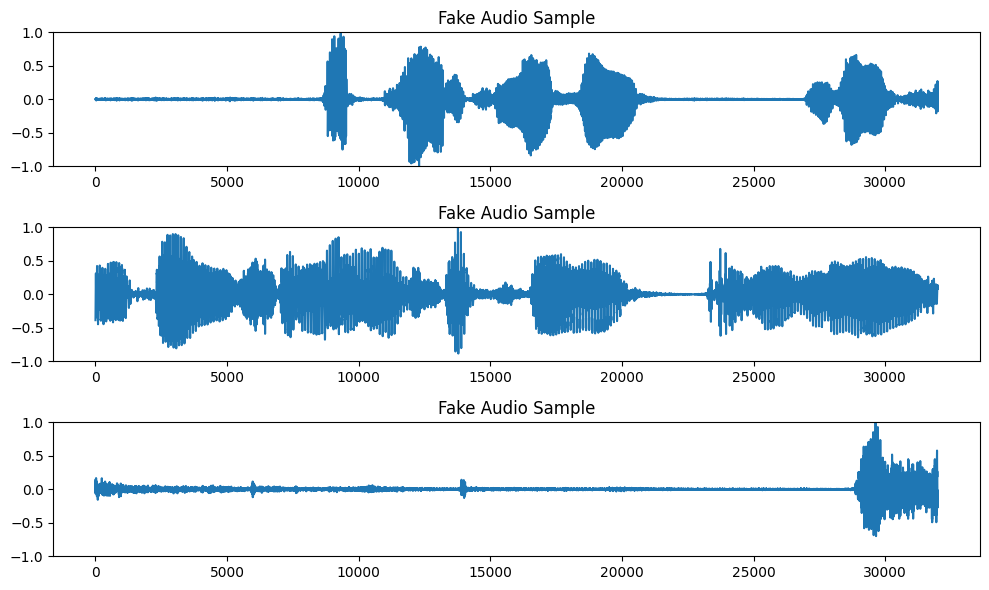


Sample audio shape: torch.Size([1, 32000])
Sample label: Fake

Model Summary:
AudioClassifier(
  (model): ImprovedRawNet(
    (conv_stem): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (block1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Sequential(
    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
D:\anaconda\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\abhis\checkpoints exists and is not empty.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ImprovedRawNet   | 431 K  | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_acc     | BinaryAccuracy   | 0      | train
3 | val_acc       | BinaryAccuracy   | 0      | train
4 | train_f1      | BinaryF1Score    | 0      | train
5 | val_f1        | BinaryF1Score    | 0      | train
6 | val_precision | BinaryPrecision  | 0      | train
7 | val_recall    | BinaryRecall     | 0      | train
-----------------------------------------------------------
431 K     Trainable params
0         Non-trainable params
431 K     Total params
1.725     Total estimated model params size (


Starting training...


Sanity Checking: |                                                                               | 0/? [00:00<…

D:\anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



Epoch 0 - Validation batch predictions:
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual labels: [1 1 1 1 1 1 1 0 1 1 1 1 0]
Logits: [[0.39473638 0.6052636 ]
 [0.4450341  0.5549659 ]
 [0.39108825 0.60891175]
 [0.3733147  0.6266853 ]
 [0.38460967 0.61539036]
 [0.36744824 0.6325518 ]
 [0.37773114 0.62226886]
 [0.34818432 0.6518157 ]
 [0.36081815 0.6391819 ]
 [0.3699635  0.63003653]
 [0.37356576 0.62643427]
 [0.4176646  0.5823354 ]
 [0.3782745  0.6217255 ]]


D:\anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…


Epoch 0 - Training batch predictions:
Predictions: [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1]
Actual labels: [1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1]
Logits: [[1.6585802e-01 8.3414197e-01]
 [1.3530788e-13 1.0000000e+00]
 [2.6868937e-12 1.0000000e+00]
 [9.2008215e-04 9.9907994e-01]
 [9.4479555e-01 5.5204462e-02]
 [5.1449595e-19 1.0000000e+00]
 [2.8918817e-10 1.0000000e+00]
 [1.1619870e-03 9.9883801e-01]
 [6.9979029e-07 9.9999928e-01]
 [9.7111601e-01 2.8883949e-02]
 [3.3574726e-02 9.6642524e-01]
 [6.5230488e-14 1.0000000e+00]
 [4.3675030e-08 1.0000000e+00]
 [1.6637937e-04 9.9983358e-01]
 [2.3057433e-12 1.0000000e+00]
 [2.0171624e-09 1.0000000e+00]]


Validation: |                                                                                    | 0/? [00:00<…


Epoch 0 - Validation batch predictions:
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual labels: [1 1 1 1 1 1 1 0 1 1 1 1 0]
Logits: [[2.7097474e-04 9.9972898e-01]
 [2.9788996e-04 9.9970204e-01]
 [2.9900481e-04 9.9970102e-01]
 [2.7226959e-04 9.9972767e-01]
 [2.6780867e-04 9.9973220e-01]
 [2.9446764e-04 9.9970549e-01]
 [2.6886194e-04 9.9973112e-01]
 [2.8254435e-04 9.9971741e-01]
 [2.4149791e-04 9.9975854e-01]
 [2.5638359e-04 9.9974364e-01]
 [2.5589883e-04 9.9974412e-01]
 [2.8646705e-04 9.9971348e-01]
 [2.6751444e-04 9.9973243e-01]]


Metric val_f1 improved. New best score: 0.917


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…


Epoch 3 - Training batch predictions:
Predictions: [1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1]
Actual labels: [1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1]
Logits: [[1.5804174e-08 1.0000000e+00]
 [6.8852962e-05 9.9993110e-01]
 [3.5189914e-05 9.9996483e-01]
 [2.2343589e-02 9.7765642e-01]
 [9.8289759e-09 1.0000000e+00]
 [5.4136518e-02 9.4586349e-01]
 [5.4439358e-02 9.4556057e-01]
 [7.7043820e-09 1.0000000e+00]
 [1.2611658e-02 9.8738831e-01]
 [1.3627425e-06 9.9999869e-01]
 [7.7317218e-08 9.9999988e-01]
 [9.7674155e-01 2.3258494e-02]
 [2.6594829e-05 9.9997342e-01]
 [9.9999976e-01 2.7893228e-07]
 [1.4652306e-04 9.9985349e-01]
 [1.3916948e-08 1.0000000e+00]]


Validation: |                                                                                    | 0/? [00:00<…


Epoch 3 - Validation batch predictions:
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual labels: [1 1 1 1 1 1 1 0 1 1 1 1 0]
Logits: [[5.4761795e-10 1.0000000e+00]
 [4.4081300e-10 1.0000000e+00]
 [7.3572637e-10 1.0000000e+00]
 [7.6548690e-10 1.0000000e+00]
 [6.8707118e-10 1.0000000e+00]
 [1.2482991e-09 1.0000000e+00]
 [6.4995526e-10 1.0000000e+00]
 [7.0450179e-10 1.0000000e+00]
 [9.0656904e-10 1.0000000e+00]
 [5.9157995e-10 1.0000000e+00]
 [6.5677813e-10 1.0000000e+00]
 [4.3011236e-10 1.0000000e+00]
 [6.3306710e-10 1.0000000e+00]]


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…


Epoch 6 - Training batch predictions:
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
Actual labels: [1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
Logits: [[4.3486756e-07 9.9999952e-01]
 [2.6676978e-03 9.9733233e-01]
 [6.9886994e-14 1.0000000e+00]
 [2.5712485e-05 9.9997425e-01]
 [4.9428236e-11 1.0000000e+00]
 [6.1494467e-07 9.9999940e-01]
 [1.2912184e-12 1.0000000e+00]
 [4.7421632e-05 9.9995255e-01]
 [3.7161750e-05 9.9996281e-01]
 [5.4663101e-09 1.0000000e+00]
 [2.0937446e-06 9.9999785e-01]
 [4.4733852e-01 5.5266148e-01]
 [6.6067191e-06 9.9999344e-01]
 [5.5297130e-01 4.4702876e-01]
 [2.0858454e-07 9.9999976e-01]
 [7.9314327e-03 9.9206853e-01]]


Validation: |                                                                                    | 0/? [00:00<…


Epoch 6 - Validation batch predictions:
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual labels: [1 1 1 1 1 1 1 0 1 1 1 1 0]
Logits: [[8.3354401e-04 9.9916649e-01]
 [2.0310836e-04 9.9979693e-01]
 [1.4965606e-03 9.9850345e-01]
 [1.9130782e-03 9.9808693e-01]
 [2.2185429e-03 9.9778146e-01]
 [6.1685974e-03 9.9383140e-01]
 [1.3018430e-03 9.9869812e-01]
 [2.8064116e-03 9.9719363e-01]
 [5.1178765e-03 9.9488211e-01]
 [1.7214646e-03 9.9827850e-01]
 [1.6844326e-03 9.9831557e-01]
 [2.3982632e-04 9.9976021e-01]
 [8.8419631e-04 9.9911577e-01]]


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…


Epoch 9 - Training batch predictions:
Predictions: [1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0]
Actual labels: [1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1]
Logits: [[8.4228730e-03 9.9157715e-01]
 [1.1562737e-02 9.8843724e-01]
 [4.6536547e-06 9.9999535e-01]
 [9.9092299e-01 9.0770610e-03]
 [9.9847442e-01 1.5256273e-03]
 [2.7192624e-03 9.9728072e-01]
 [5.5218834e-01 4.4781163e-01]
 [1.0000000e+00 2.3981142e-09]
 [1.3624033e-06 9.9999869e-01]
 [1.4769288e-08 1.0000000e+00]
 [6.8740290e-01 3.1259710e-01]
 [1.4686422e-02 9.8531359e-01]
 [4.8583735e-15 1.0000000e+00]
 [3.4205611e-03 9.9657947e-01]
 [3.8564730e-25 1.0000000e+00]
 [9.9998224e-01 1.7702350e-05]]


Validation: |                                                                                    | 0/? [00:00<…


Epoch 9 - Validation batch predictions:
Predictions: [1 1 1 0 0 0 0 1 0 0 0 1 1]
Actual labels: [1 1 1 1 1 1 1 0 1 1 1 1 0]
Logits: [[0.16536494 0.834635  ]
 [0.01252541 0.98747456]
 [0.2949898  0.70501024]
 [0.5290112  0.47098875]
 [0.6770184  0.3229816 ]
 [0.7205904  0.27940956]
 [0.5112601  0.48873994]
 [0.46927103 0.53072894]
 [0.7288965  0.27110353]
 [0.59133077 0.40866917]
 [0.5656404  0.43435964]
 [0.03088826 0.96911174]
 [0.15659827 0.8434017 ]]


Validation: |                                                                                    | 0/? [00:00<…

Monitored metric val_f1 did not improve in the last 10 records. Best score: 0.917. Signaling Trainer to stop.



Best model saved at: C:\Users\abhis\checkpoints\best-model-epoch=00-val_loss=4.73-val_f1=0.92-v1.ckpt

Validation results:


Validation: |                                                                                    | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8461538553237915     │
│          val_f1           │    0.9166666865348816     │
│         val_loss          │    3.5538716316223145     │
│       val_precision       │    0.8461538553237915     │
│        val_recall         │            1.0            │
└───────────────────────────┴───────────────────────────┘

Validation Loss: 3.5539
Validation Accuracy: 0.8462
Validation F1 Score: 0.9167
Validation Precision: 0.8462
Validation Recall: 1.0000

Final Results (Best Model):


Validation: |                                                                                    | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8461538553237915     │
│          val_f1           │    0.9166666865348816     │
│         val_loss          │     4.730311870574951     │
│       val_precision       │    0.8461538553237915     │
│        val_recall         │            1.0            │
└───────────────────────────┴───────────────────────────┘

Best Model Validation Loss: 4.7303
Best Model Validation Accuracy: 0.8462
Best Model Validation F1 Score: 0.9167
Best Model Validation Precision: 0.8462
Best Model Validation Recall: 1.0000


In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from glob import glob
import os
import zipfile
import random
import numpy as np
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinaryRecall
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler
# Set environment variables to limit threads
os.environ["OMP_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1"

# Set fixed random seed for reproducibility
random_seed = 42
pl.seed_everything(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Constants
TARGET_LENGTH = 32000  # ~2 seconds at 16kHz
SAMPLE_RATE = 16000    # Target sample rate
BATCH_SIZE = 16        # Batch size
LEARNING_RATE = 3e-4   # Slightly higher learning rate
MAX_EPOCHS = 30        # Increased max epochs
PATIENCE = 10          # Increased patience for early stopping

class RawAudioDataset(Dataset):
    def __init__(self, file_paths, labels, target_length=TARGET_LENGTH, sample_rate=SAMPLE_RATE, augment=False):
        self.file_paths = file_paths
        self.labels = labels
        self.target_length = target_length
        self.sample_rate = sample_rate
        self.augment = augment  # Flag to control augmentation
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        for attempt in range(3):  # Try loading up to 3 times
            try:
                # Load audio file
                file_path = self.file_paths[idx]
                if not os.path.exists(file_path):
                    raise FileNotFoundError(f"File not found: {file_path}")
                
                waveform, sr = torchaudio.load(file_path)
                
                # Skip if empty
                if waveform.nelement() == 0:
                    raise RuntimeError("Empty audio file")
                
                # Check for invalid values
                if torch.isnan(waveform).any() or torch.isinf(waveform).any():
                    raise ValueError("File contains NaN or Inf values")
                
                # Resample if needed
                if sr != self.sample_rate:
                    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
                    waveform = resampler(waveform)
                
                # Handle channels - convert to mono by averaging channels
                if waveform.size(0) > 1:
                    waveform = waveform.mean(dim=0, keepdim=True)
                
                # Apply augmentations if enabled (training)
                if self.augment:
                    # Random gain adjustment (volume change)
                    if random.random() > 0.5:
                        gain_factor = random.uniform(0.7, 1.3)
                        waveform = waveform * gain_factor
                    
                    # Random time shift
                    if random.random() > 0.5:
                        shift_amount = int(random.uniform(0, 0.2) * self.target_length)
                        waveform = torch.roll(waveform, shifts=shift_amount, dims=1)
                    
                    # Add small gaussian noise (simulates recording noise)
                    if random.random() > 0.5:
                        noise_level = random.uniform(0.001, 0.005)
                        noise = torch.randn_like(waveform) * noise_level
                        waveform = waveform + noise
                    
                    # Random pitch shift (using torchaudio's implementation)
                    if random.random() > 0.7:
                        pitch_shift = random.randint(-2, 2)  # Shift by up to 2 semitones
                        if pitch_shift != 0:
                            waveform = torchaudio.functional.pitch_shift(
                                waveform, sr, pitch_shift, bins_per_octave=12)
                
                # Pad/truncate to target length
                if waveform.size(1) > self.target_length:
                    # Random segment for augmentation, centered segment for validation
                    if self.augment:
                        start = random.randint(0, waveform.size(1) - self.target_length)
                    else:
                        start = (waveform.size(1) - self.target_length) // 2  # Center
                    waveform = waveform[:, start:start+self.target_length]
                else:
                    # For shorter samples, use reflection padding to avoid discontinuities
                    pad_amount = self.target_length - waveform.size(1)
                    waveform = F.pad(waveform, (0, pad_amount), mode='reflect')
                
                # Normalize to range [-1, 1] before returning
                if waveform.abs().max() > 0:
                    waveform = waveform / waveform.abs().max()
                
                return waveform, self.labels[idx]
                
            except Exception as e:
                if attempt == 2:  # Final attempt
                    print(f"Failed to load {self.file_paths[idx]} after 3 attempts: {e}")
                    # Return silent audio with correct shape
                    return torch.zeros(1, self.target_length), self.labels[idx]
                continue

class ImprovedRawNet(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        # Input stem - preserve more information early on
        self.conv_stem = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool1d(4),  # 32000 -> 8000
        )
        
        # Feature extraction blocks
        self.block1 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool1d(4),  # 8000 -> 2000
        )
        
        self.block2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool1d(4),  # 2000 -> 500
        )
        
        self.block3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.MaxPool1d(5),  # 500 -> 100
        )
        
        # Global pooling
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 2)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv_stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x)
        return self.fc(x)

class AudioClassifier(pl.LightningModule):
    def __init__(self, model, learning_rate=LEARNING_RATE, class_weights=None):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        
        # Use weighted loss if class weights are provided
        if class_weights is not None:
            self.class_weights = class_weights.to(self.device if self.device else torch.device('cpu'))
            self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            self.loss_fn = nn.CrossEntropyLoss()
        
        # Enhanced metrics
        self.train_acc = BinaryAccuracy()
        self.val_acc = BinaryAccuracy()
        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()
        self.val_precision = BinaryPrecision()
        self.val_recall = BinaryRecall()
        
        # For plotting
        self.train_losses = []
        self.val_losses = []
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        
        preds = torch.argmax(logits, dim=1)
        self.train_acc(preds, y)
        self.train_f1(preds, y)
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_f1", self.train_f1, on_step=False, on_epoch=True, prog_bar=True)
        self.train_losses.append(loss.detach().cpu().numpy())
        
        # Log predictions for debugging (only once per epoch)
        if batch_idx == 0 and self.current_epoch % 3 == 0:
            print(f"\nEpoch {self.current_epoch} - Training batch predictions:")
            print(f"Predictions: {preds.cpu().numpy()}")
            print(f"Actual labels: {y.cpu().numpy()}")
            print(f"Logits: {torch.softmax(logits, dim=1).detach().cpu().numpy()}")
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        
        preds = torch.argmax(logits, dim=1)
        self.val_acc(preds, y)
        self.val_f1(preds, y)
        self.val_precision(preds, y)
        self.val_recall(preds, y)
        
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True)
        self.log("val_f1", self.val_f1, on_epoch=True, prog_bar=True)
        self.log("val_precision", self.val_precision, on_epoch=True)
        self.log("val_recall", self.val_recall, on_epoch=True)
        self.val_losses.append(loss.detach().cpu().numpy())
        
        # Log predictions for debugging
        if batch_idx == 0 and self.current_epoch % 3 == 0:
            print(f"\nEpoch {self.current_epoch} - Validation batch predictions:")
            print(f"Predictions: {preds.cpu().numpy()}")
            print(f"Actual labels: {y.cpu().numpy()}")
            print(f"Logits: {torch.softmax(logits, dim=1).detach().cpu().numpy()}")
        
        return loss
    
    def on_train_epoch_end(self):
        # Plot losses at the end of each epoch
        if len(self.train_losses) > 0 and len(self.val_losses) > 0:
            plt.figure(figsize=(10, 5))
            
            # Apply moving average for smoother visualization
            window_size = min(10, len(self.train_losses)//2)
            if window_size > 1:
                train_smooth = np.convolve(
                    self.train_losses, np.ones(window_size)/window_size, mode='valid')
                val_smooth = np.convolve(
                    self.val_losses, np.ones(window_size)/window_size, mode='valid')
                
                plt.plot(train_smooth, label='Train Loss')
                plt.plot(val_smooth, label='Validation Loss')
            else:
                plt.plot(self.train_losses, label='Train Loss')
                plt.plot(self.val_losses, label='Validation Loss')
                
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.legend()
            plt.title(f'Training and Validation Loss - Epoch {self.current_epoch}')
            plt.savefig(f'loss_plot_epoch_{self.current_epoch}.png')
            plt.close()
    
    def configure_optimizers(self):
        # Use AdamW with weight decay for better regularization
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.learning_rate,
            weight_decay=1e-5
        )
        
        # Cosine annealing scheduler with warm restarts
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, 
            T_0=5,  # Restart every 5 epochs
            T_mult=1, 
            eta_min=self.learning_rate/10
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

def visualize_samples(dataset, num_samples=3, title="Sample Waveforms"):
    """Visualize audio waveforms from the dataset"""
    plt.figure(figsize=(10, 6))
    
    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        waveform, label = dataset[idx]
        
        plt.subplot(num_samples, 1, i+1)
        plt.plot(waveform.numpy()[0])
        plt.title(f"{'Real' if label == 0 else 'Fake'} Audio Sample")
        plt.ylim(-1, 1)
        
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

def prepare_data(data_path):
    """Process audio data and prepare datasets with enhanced validation"""
    # Get all audio files (recursive search)
    all_files = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.wav'):
                all_files.append(os.path.join(root, file))
    
    if not all_files:
        raise ValueError(f"No WAV files found in {data_path}. Please check your data directory.")
    
    # Create labels (0 for bonafide/real, 1 for spoof/fake)
    labels = []
    for f in all_files:
        path = os.path.normpath(f).lower()
        if 'real' in path or 'bonafide' in path or 'original' in path:
            labels.append(0)
        elif 'fake' in path or 'spoof' in path:
            labels.append(1)
        else:
            print(f"Warning: Could not determine label for {f} - defaulting to 0")
            labels.append(0)
    
    # Verify all files can be loaded with enhanced validation
    valid_files = []
    valid_labels = []
    for f, label in zip(all_files, labels):
        try:
            # Check if file exists
            if not os.path.exists(f):
                print(f"File not found: {f}")
                continue
                
            # Check file size (skip if too small)
            if os.path.getsize(f) < 100:  # Arbitrary small size in bytes
                print(f"File too small, likely corrupted: {f}")
                continue
                
            # Try loading the file
            waveform, sr = torchaudio.load(f)
            
            # Validate waveform
            if waveform.nelement() == 0:
                print(f"Empty waveform in file: {f}")
                continue
                
            if torch.isnan(waveform).any() or torch.isinf(waveform).any():
                print(f"File contains NaN or Inf values: {f}")
                continue
                
            # If all checks pass, add to valid files
            valid_files.append(f)
            valid_labels.append(label)
            
        except Exception as e:
            print(f"Skipping corrupt file: {f} - {str(e)}")
    
    print(f"\nDataset Summary:")
    print(f"Total files found: {len(all_files)}")
    print(f"Valid files: {len(valid_files)}")
    print(f"Training set: {len(valid_files)} files ({sum(valid_labels)} fake, {len(valid_labels)-sum(valid_labels)} real)")
    
    # Split into train and validation sets with stratification
    train_files, val_files, train_labels, val_labels = train_test_split(
        valid_files, valid_labels, test_size=0.2, random_state=random_seed, stratify=valid_labels)
    
    print(f"\nFinal Split:")
    print(f"Training set: {len(train_files)} files ({sum(train_labels)} fake, {len(train_labels)-sum(train_labels)} real)")
    print(f"Validation set: {len(val_files)} files ({sum(val_labels)} fake, {len(val_labels)-sum(val_labels)} real)")
    
    return train_files, val_files, train_labels, val_labels

def get_weighted_sampler(labels):
    """Create a weighted sampler to handle class imbalance"""
    class_counts = torch.bincount(torch.tensor(labels))
    class_weights = 1. / class_counts.float()
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler, class_weights

def main():
    # Data path configuration
    data_path = 'audio_data'
    if not os.path.exists(data_path):
        zip_path = 'archive (1).zip'
        if os.path.exists(zip_path):
            print("Extracting dataset...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(data_path)
        else:
            raise FileNotFoundError(f"Neither {data_path} nor {zip_path} found. Please provide the dataset.")
    
    # Create output directories
    os.makedirs('logs', exist_ok=True)
    os.makedirs('checkpoints', exist_ok=True)
    
    # Prepare data
    train_files, val_files, train_labels, val_labels = prepare_data(data_path)
    
    # Create datasets with augmentation for training
    train_dataset = RawAudioDataset(train_files, train_labels, augment=True)  # Enable augmentation
    val_dataset = RawAudioDataset(val_files, val_labels, augment=False)  # No augmentation for validation
    
    # Create weighted sampler to handle class imbalance
    train_sampler, class_weights = get_weighted_sampler(train_labels)

    # Start with safer DataLoader settings
    num_workers = 0  # Start with 0 and increase if stable
    
    # Visualize sample waveforms
    visualize_samples(train_dataset, num_samples=3, title="Original Training Samples")
    
    # Test one sample
    test_sample, test_label = train_dataset[0]
    print(f"\nSample audio shape: {test_sample.shape}")
    print(f"Sample label: {'Fake' if test_label == 1 else 'Real'}")
    
    # Create dataloaders
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler if num_workers > 0 else None,
        shuffle=True if num_workers == 0 else False,  # Use shuffle if not using sampler
        num_workers=num_workers,
        pin_memory=(num_workers > 0),
        persistent_workers=(num_workers > 0),
        timeout=60 if num_workers > 0 else 0  # Only set timeout when using workers
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=(num_workers > 0),
        persistent_workers=(num_workers > 0),
        timeout=60 if num_workers > 0 else 0  # Only set timeout when using workers
    )
    
    # Setup logging and checkpointing
    logger = CSVLogger('logs', name='audio_classifier')
    checkpoint_callback = ModelCheckpoint(
        dirpath='checkpoints',
        filename='best-model-{epoch:02d}-{val_loss:.2f}-{val_f1:.2f}',
        save_top_k=3,  # Save top 3 models
        monitor='val_f1',
        mode='max'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_f1',
        patience=PATIENCE,
        verbose=True,
        mode='max'
    )
    
    # Create model with class weights for loss function
    model = ImprovedRawNet(dropout_rate=0.3)
    classifier = AudioClassifier(model, learning_rate=LEARNING_RATE, class_weights=class_weights)
    
    # Print model summary
    print("\nModel Summary:")
    print(classifier)
    
    # Calculate total size of model parameters
    model_size = sum(p.numel() for p in classifier.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {model_size:,}")
    
    # Train the model
    trainer = pl.Trainer(
        max_epochs=MAX_EPOCHS,
        logger=logger,
        callbacks=[checkpoint_callback, early_stop_callback],
        accelerator='auto',
        devices=1,
        log_every_n_steps=1,  # Log more frequently
        deterministic=True,
        gradient_clip_val=1.0,  # Prevent exploding gradients
    )
    
    print("\nStarting training...")
    trainer.fit(classifier, train_loader, val_loader)
    
    # Print path to best model
    print(f"\nBest model saved at: {checkpoint_callback.best_model_path}")
    
    # Validate the model
    print("\nValidation results:")
    val_results = trainer.validate(classifier, val_loader)
    print(f"Validation Loss: {val_results[0]['val_loss']:.4f}")
    print(f"Validation Accuracy: {val_results[0]['val_acc']:.4f}")
    print(f"Validation F1 Score: {val_results[0]['val_f1']:.4f}")
    print(f"Validation Precision: {val_results[0]['val_precision']:.4f}")
    print(f"Validation Recall: {val_results[0]['val_recall']:.4f}")
    
    # Load best model and run validation
    best_model = AudioClassifier.load_from_checkpoint(
        checkpoint_callback.best_model_path, 
        model=model,
        class_weights=class_weights
    )
    
    print("\nFinal Results (Best Model):")
    final_results = trainer.validate(best_model, val_loader)
    print(f"Best Model Validation Loss: {final_results[0]['val_loss']:.4f}")
    print(f"Best Model Validation Accuracy: {final_results[0]['val_acc']:.4f}")
    print(f"Best Model Validation F1 Score: {final_results[0]['val_f1']:.4f}")
    print(f"Best Model Validation Precision: {final_results[0]['val_precision']:.4f}")
    print(f"Best Model Validation Recall: {final_results[0]['val_recall']:.4f}")

if __name__ == "__main__":
    # Make sure multiprocessing setup is done first
    torch.multiprocessing.freeze_support()
    if torch.multiprocessing.get_start_method() != 'spawn':
        torch.multiprocessing.set_start_method('spawn', force=True)
    
    # Optional: Test a single sample explicitly before full training
    try:
        data_path = 'audio_data'
        train_files, val_files, train_labels, val_labels = prepare_data(data_path)
        test_dataset = RawAudioDataset([train_files[0]], [train_labels[0]])
        test_item = test_dataset[0]
        print(f"Test item successfully loaded: {test_item[0].shape}, label: {test_item[1]}")
    except Exception as e:
        print(f"Error during test load: {e}")
    
    # Now run the main function
    main()